In [53]:
# IANNwTF_Homework 06 - ResNet and DenseNet

import matplotlib.pyplot as plt
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [54]:
class Block(tf.keras.layers.Layer):
    """
    Block structure for DenseNet based on the original paper's 'conv' block, which consists of BatchNorm-Relu-Conv
    """
    def __init__(self, f=32, k=1, s=1):
        super(Block, self).__init__()
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.Activation('relu')
        self.conv = tf.keras.layers.Conv2D(filters=f, kernel_size=k, strides=s, padding='same')
    @tf.function
    def call(self, x, training=True): #Do we need training for batchnorm?
        x = self.batchnorm(x, training)
        x = self.relu(x)
        x = self.conv(x)
        return x

In [55]:
class TransitionLayer(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(TransitionLayer, self).__init__()
        self.sub_block = Block(channels, k=2, s=2) #added stride and kernel size
        self.avgpool = tf.keras.layers.AvgPool2D(2, strides=2, padding='same')
    @tf.function
    def call(self, x, training=True):
        x = self.sub_block(x, training)
        x = self.avgpool(x)
        return x

In [56]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, filters=32):  #add num_blocks if necessary
        
        super(DenseBlock, self).__init__()
        #first dense block has 4*filters
        self.sub_block_1 = Block(f=filters*4)
        self.sub_block_2 = Block(f=filters, k=3)
        """
        super(DenseBlock, self).__init__()
        #first dense block has 4*filters
        self.block_list = []
        sub_block_1 = Block(f=filters*4)
        self.block_list.append(sub_block_1)
        num_blocks -= 1

        for each in range(num_blocks):
            self.block_list.append(Block(f=filters)))
        """
    @tf.function
    def call(self, x, training=True):
        x_original = x #copy input for concatenation
        
        x = self.sub_block_1(x, training)
        x = self.sub_block_2(x, training)
        """
        for each in self.block_list:
            x = each(x)
        """
        #print("x.shape: ", x.shape, "x_original.shape: ",x_original.shape)
        x = tf.keras.layers.Concatenate()([x, x_original])
        #print("new shape", x.shape)
        return x


In [57]:
class DenseNet(tf.keras.Model):
    def __init__(self, growth_rate, group_num, group_counts):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        #Number of DenseBlocks in each group
        self.group_num = group_num
        self.group_counts = group_counts

        if group_num != len(group_counts):
            raise IndexError("Number of DenseBlock groups group_num doesn't match provided group_counts list")

        self.dense_group_lists = []
        self.transition_list = []

        num_channels = 0 #number of channels for transition layer

        #Pre-DenseBlock layers
        #start with 64 filters
        self.pre_conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same') #old kernel_size = 7, strides = 2
        #self.pre_pool = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same')

        #First Dense Group
        for i in range(self.group_num):  #for each group
            #make a list of blocks
            group_list = []
            #populate group_list based on group_counts[i]
            for j in range(self.group_counts[i]):
                group_list.append(DenseBlock())
            self.dense_group_lists.append(group_list)

            #Only do the below if the current group is not the last group
            if i != self.group_num - 1:
                #sum up total number of DenseBlocks for calculation of num_channels for TransitionLayer
                num_channels += self.group_counts[i] * self.growth_rate
                #add transition layer for each group of DenseBlocks
                self.transition_list.append(TransitionLayer(num_channels // 2))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.global_avgpool = tf.keras.layers.GlobalAvgPool2D()
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
            
    @tf.function
    def call(self, x, training=True):
        #Pre-DenseBlock calls
        x = self.pre_conv(x)
        #x = self.pre_pool(x)

        for i in range(self.group_num):
            for j in range(len(self.dense_group_lists[i])):
                x = self.dense_group_lists[i][j](x, training)
            #pass to transition layer before moving onto next group
            #only if it isn't the last group
            if i != self.group_num - 1:
                x = self.transition_list[i](x)
        #Post-DenseBlock calls
        x = self.batchnorm(x)
        x = self.global_avgpool(x)
        x = self.output_layer(x)
        return x



In [58]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, stride_count = 2):
        super(ResidualBlock, self).__init__()
        filter1, filter2, filter3 = filters    #filter1=64, filter2=64, filter3=256
        
        #First layer
        self.conv_1 = tf.keras.layers.Conv2D(filters=filter1, kernel_size=(1), strides=(stride_count,stride_count))
        self.batchnorm_1 = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image
        self.activation_1 = tf.keras.layers.Activation('relu')
        #Second layer
        self.conv_2 = tf.keras.layers.Conv2D(filters=filter2, kernel_size=(3), strides=(stride_count,stride_count), padding='same')
        self.batchnorm_2 = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image
        self.activation_2 = tf.keras.layers.Activation('relu')

        #Third layer
        self.conv_3 = tf.keras.layers.Conv2D(filters=filter3, kernel_size=(1), strides=(stride_count,stride_count), padding='valid')
        self.batchnorm_3 = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image
        self.activation_3 = tf.keras.layers.Activation('relu')

        #Skip step layer (converting input to same size as output for addition)
        #Choose s to get the appropriate size to match x_skip.shape to x.shape.
        #Formula used to determine output size: floor(((n-f)/s) + 1) = output_dim, where n is the original input dimension(assuming same height or width), f is the kernel size, and s is the stride.
        #x_skip.shape:  (64, 32, 32, 64) x.shape:  (64, 4, 4, 256) <- based on testing readout. Goal: convert dim of 32 to dim of 4
        #n = 32, f = 1 (1x1 convolution), output_dim = 4
        #((32-1)/s)+ 1 = 4, pick s = 8
        #floor(31/8 + 1) = 3
        self.conv_1x1 = tf.keras.layers.Conv2D(filters=filter3, kernel_size=(1), strides=(8,8), padding='valid')  #use filter3 to convert number of channels of input to match the third layer
        self.batchnorm_skip = tf.keras.layers.BatchNormalization(axis = 3) #Assuming 3 channels from RGB image

    @tf.function
    def call(self, x, training=True):
        x_skip = x #duplicating input to be used in skip step
      
        #First layer calls
        x = self.conv_1(x)
        x = self.batchnorm_1(x, training)
        x = self.activation_1(x)

        #Second layer calls
        x = self.conv_2(x)
        x = self.batchnorm_2(x, training)
        x = self.activation_2(x)

        #Third layer calls
        x = self.conv_3(x)
        x = self.batchnorm_3(x, training)
      
        #if input shape differs from output shape, modify input before addition
        
        #print("x_skip.shape: ", x_skip.shape, "x.shape: ", x.shape)
        if(x_skip.shape != x.shape):
            x_skip = self.conv_1x1(x_skip)
            x_skip = self.batchnorm_skip(x_skip, training)
        #print("x_skip.shape: ", x_skip.shape, "x.shape: ", x.shape)
        #perform addition of input to output before activation function
        x = tf.keras.layers.add([x, x_skip])
        x = self.activation_3(x)

        return x

In [59]:
class ResNet(tf.keras.Model):
    def __init__(self):
        
        #removed resblock_count and block_filters so that multiple resblocks with different counts and filters can be implemented
        #set resblock_counts and resblock_filters for each block here. first two examples are given
        self.resblock_count_1 = 2
        self.resblock_filters_1 = (64, 64, 256)
        self.resblock_count_2 = 2
        self.resblock_filters_2 = (128,128,512)
        super(ResNet, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters=64, #WHAT IS THE APPROPRIATE FILTER COUNT/KERNEL SIZE
                                         kernel_size=3,
                                         padding="same",
                                         input_shape=(32, 32, 3), 
                                         kernel_regularizer="l2",
                                         bias_regularizer="l2")
        
        #Add more resblock_lists here for each group of blocks. Declare the lists before using them
        self.resblock_list_1 = [ResidualBlock(self.resblock_filters_1) for each in range(self.resblock_count_1)]
        self.resblock_list_2 = [ResidualBlock(self.resblock_filters_2) for each in range(self.resblock_count_2)]
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D(data_format="channels_last")
        self.output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)

    @tf.function
    def call(self, x, training=True):
        x = self.conv_1(x)
        
        #Add more loops for each resblock_list you have
        for each in range(self.resblock_count_1):
            x = self.resblock_list_1[each](x, training)
        for each in range(self.resblock_count_2):
            x = self.resblock_list_1[each](x, training)
            
        x = self.global_pool(x)
        x = self.output_layer(x)
        return x

In [60]:
def train_step(model, input, target, loss_function, optimizer):
  # if using dropout, add: training=True
  with tf.GradientTape() as tape:
    # for dropout, use: prediction = model(input, training)
    prediction = model(input)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function, training=False):
  test_losses = []
  test_accuracies = []
    
  for (input, target) in test_data:
    # prediction = model(input, training)
    prediction = model(input, training)
    sample_test_loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    
    # print('line 20: sample_test_loss is ', sample_test_loss)
    # axis=0 is the batch_size, axis=1 is the one-hot encoding of the labels
        
    sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    
    test_losses.append(sample_test_loss.numpy())
    # compute the sample_test_accuracy for each batch before appending
    test_accuracies.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_losses)
  test_accuracy = np.mean(test_accuracies)

  return test_loss, test_accuracy    

In [61]:
# visualize accuracy and loss for train_ds & test_ds
def plot(train_losses, test_losses, test_accuracies, figsize=(10,3)):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
  axes[0].plot(train_losses, label='train')
  axes[0].plot(test_losses, label='test')
  axes[0].set_xlabel('Epoches')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss', fontsize=20)
  axes[0].legend()
  axes[1].plot(test_accuracies)
  axes[1].set_xlabel('Epoches')
  axes[1].set_ylabel('Accuracy')
  plt.ylim(0,1.0)
  axes[1].set_title('Accuracy' + str(round(np.max(test_accuracies))), fontsize=20)
  plt.show()

In [62]:
# implementation credits go to Group 16's Week04 homework
# option 1: gaussian standard distribution
def norm_std():
  return tf.image.per_image_standardization(image)

# option 2: normalize to (0,1)
def norm_0_1(x):
  max = 255
  min = 0
  result = tf.math.subtract(x, min)
  norm_image = tf.math.divide(result, (max - min))
  return norm_image

# option 3: normalize to (-1,1)
def norm_neg_1(x):
  result = norm_0_1(x)
  result = tf.math.multiply(result, 2)
  norm_image = tf.math.subtract(result, 1)
  return norm_image

In [63]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# train_ds, test_ds = tf.keras.datasets.cifar10.load_data()

# train_ds = train_ds[:10000]
# test_ds = test_ds[11000:15000]
# Here we take the first 10000 images for training, another 4000 images for testing
# as a starting point to build the whole pipeline 
# train_images = train_images[:10000]
# train_labels = train_labels[:10000]
# test_images = test_images[11000:15000]
# test_labels = test_labels[11000:15000]

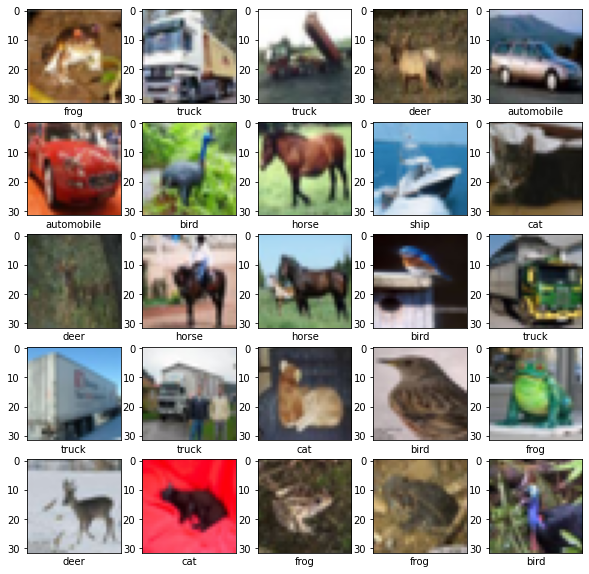

In [64]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.xticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [65]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)
print(np.max(train_images[0])) # --> max pixel value: 255
print(np.min(train_images[0]))

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
255
0


In [66]:
# confirming the pixel range of the images: (0,255)
# this will be used for normalization
max = 0
min = 0 
for train_image in train_images:
  if np.max(train_image) > max:
    max = np.max(train_image)
  if np.min(train_image) < min:
    min = np.min(train_image)
print(max, min)

255 0


In [67]:
# preprocess train_ds
# Unlike the previous homework, the current images have the same size --> no resizing needed
# Here only normalization of pixel values to (-1,1) and one-hot encoding the label are performed
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)
#train_ds_images = train_ds_images.map(lambda img : tf.reshape(img, (-1,)))
train_ds_images = train_ds_images.map(lambda image: norm_neg_1(image))
train_ds_labels = tf.data.Dataset.from_tensor_slices(train_labels)
train_ds_labels = train_ds_labels.map(lambda label : tf.one_hot(label, 10))
train_ds_labels = train_ds_labels.map(lambda label: tf.reshape(label, (-1,)))

# repeat the above procedures for test_ds
test_ds_images = tf.data.Dataset.from_tensor_slices(test_images)
test_ds_images = test_ds_images.map(lambda image: norm_neg_1(image))
test_ds_labels = tf.data.Dataset.from_tensor_slices(test_labels)
test_ds_labels = test_ds_labels.map(lambda label : tf.one_hot(label, 10))
test_ds_labels = test_ds_labels.map(lambda label: tf.reshape(label, (-1,)))
# print(test_ds_labels)


train_ds = tf.data.Dataset.zip((train_ds_images, train_ds_labels))
train_ds_shuffle = train_ds.shuffle(buffer_size=10000)
train_ds_batched = train_ds_shuffle.batch(64)
train_ds_total = train_ds_batched.prefetch(tf.data.experimental.AUTOTUNE)

# repeat the above procedures for test_ds
test_ds = tf.data.Dataset.zip((test_ds_images, test_ds_labels))
test_ds_shuffle = test_ds.shuffle(buffer_size=4000)
test_ds_batched = test_ds.batch(64)
test_ds_total = test_ds_batched.prefetch(tf.data.experimental.AUTOTUNE)

In [68]:
# Helper function to test the generated dataset from tensors
train_ds_images = tf.data.Dataset.from_tensor_slices(train_images)
print(train_ds_images)

<TensorSliceDataset shapes: (32, 32, 3), types: tf.uint8>


In [69]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.0001
running_average_factor = 0.95
block_count = 3
block_filters = (64, 64, 256)

#parameters for DenseNet
dense_growth_rate = 16
#group_num must equal len(group_counts or an error will be raised.)
group_num = 4
group_counts = (4,4,4,4)


# Initialize the model
#model = ResNet()
model = DenseNet(dense_growth_rate, group_num, group_counts)
# Define the loss
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization
train_losses = []

test_losses = []
test_accuracies =[]

print("Status: testing once on test data before start")
test_loss, test_accuracy = test(model, test_ds_total, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print("Status: Check how model performs on train data once before start")
train_loss, _ = test(model, train_ds_total, cross_entropy_loss)
train_losses.append(train_loss)

# Train for num_epochs
print("Status: Starting training")
for epoch in range(num_epochs):
    print('Epoch: ', str(epoch))

    # training
    running_average = 0
    for (sample, target) in train_ds_total:
        train_loss = train_step(model, sample, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    print('running average is ', tf.get_static_value(running_average))
    train_losses.append(tf.get_static_value(running_average))
    print('Train loss in Epoch ', epoch, ' is ', tf.get_static_value(running_average))

    # testing
    test_loss, test_accuracy = test(model, test_ds_total, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print('Test loss in Epoch ', epoch, ' is ', test_loss)
    print('Test accuracy in Epoch ', epoch, ' is ', test_accuracy)
    #plot(train_losses, test_losses, test_accuracies)

Status: testing once on test data before start
Status: Check how model performs on train data once before start
Status: Starting training
Epoch:  0
running average is  1.4798902
Train loss in Epoch  0  is  1.4798902
Test loss in Epoch  0  is  1.4916936
Test accuracy in Epoch  0  is  0.4552149681528662
Epoch:  1
running average is  1.3028396
Train loss in Epoch  1  is  1.3028396
Test loss in Epoch  1  is  1.3279302
Test accuracy in Epoch  1  is  0.5161226114649682
Epoch:  2
running average is  1.1103903
Train loss in Epoch  2  is  1.1103903
Test loss in Epoch  2  is  1.1604173
Test accuracy in Epoch  2  is  0.5803144904458599
Epoch:  3
running average is  0.99980277
Train loss in Epoch  3  is  0.99980277
Test loss in Epoch  3  is  1.1047834
Test accuracy in Epoch  3  is  0.6079816878980892
Epoch:  4
running average is  0.9263442
Train loss in Epoch  4  is  0.9263442
Test loss in Epoch  4  is  1.0598004
Test accuracy in Epoch  4  is  0.6258957006369427
Epoch:  5
running average is  0.773

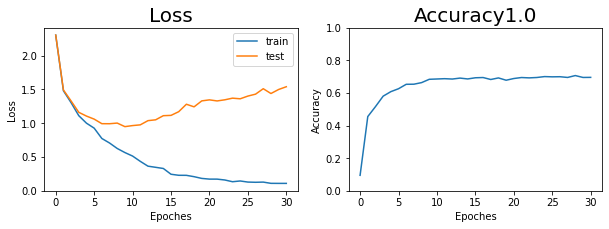

In [70]:
plot(train_losses, test_losses, test_accuracies)